# Computer Vision For Everyone With Python

### In this Computer Vision series, I publish a set of Python hands-on articles that cover both traditional image processing and deep learning based computer vision!

### I welcome you all!

#### --------------------------------------------------
#### *Articles So Far In This Series*
#### -> [[Computer Vision] Basic Image Processing](https://www.kaggle.com/rajkumarl/computer-vision-basic-image-processing)
#### -> [[Computer Vision] Linear Filtering](https://www.kaggle.com/rajkumarl/computer-vision-linear-filtering)
#### --------------------------------------------------

Datasets Used:

1. [Tea Time - Kaggle Dataset](https://www.kaggle.com/rajkumarl/tea-time)

2. [People Clothing Segmentation - Kaggle Dataset](https://www.kaggle.com/rajkumarl/people-clothing-segmentation)

References:

1. [Computer Vision: Algorithms and Applications, 2nd ed. - Richard Szeliski Textbook](https://szeliski.org/Book/)

2. [Deep Learning for Computer Vision - NPTEL Course](https://nptel.ac.in/courses/106/106/106106224/)

3. [Cross-correlation vs Auto-correlation - Tutorial](https://www.statisticshowto.com/cross-correlation/)

4. [Gaussian Filter - Wiki](https://en.wikipedia.org/wiki/Gaussian_blur)

##### Contents
1. Cross-Correlation
2. Auto-Correlation
3. Convolution
4. Properties of Convolution
5. Moving Average Filter
6. Gaussian Filter
7. Edge Filter
8. Separable Filters

Do necessary imports and download image data!

In [1]:
import numpy as np # for math operations
from scipy import stats, signal # for some probability operations
import cv2 # for image reading and conversions
import matplotlib.pyplot as plt # for image display
import os # for file handling
import urllib3 # to read data from a url
from tqdm import tqdm

# read data files from the Tea-Time dataset
tea_files = []
for dirname, _, filenames in os.walk('/kaggle/input/tea-time'):
    for filename in filenames:
        tea_files.append(str(os.path.join(dirname, filename)))
tea_files.sort()
print(tea_files[0])

# read data files from the People-Clothing-Segmentation dataset
cloth_files = []
for dirname, _, filenames in os.walk('/kaggle/input/people-clothing-segmentation/jpeg_images/IMAGES'):
    for filename in filenames:
        cloth_files.append(str(os.path.join(dirname, filename)))
cloth_files.sort()
print(cloth_files[0])

/kaggle/input/tea-time/001.jpg
/kaggle/input/people-clothing-segmentation/jpeg_images/IMAGES/img_0001.jpeg


Two datasets both containing JPEG images are available now for our image processing tasks. 

## 1. Cross-Correlation

Correlation is the process of manipulating two images by overlapping each other. In Cross-correlation, one image is specifically called *image* and the another is called *filter / mask / kernel* in the computer vision domain. The Manipulation here is a simple dot product between the image and the filter. If the filter size is different from the image size, the filter is slided over the image window-by-window to cover each and every pixel of image (and filter). The pixel values of filter are called *filter coefficients*. Since the filter coefficients DO NOT vary during window-sliding operation, this process can be generally termed *LINEAR FILTERING.*

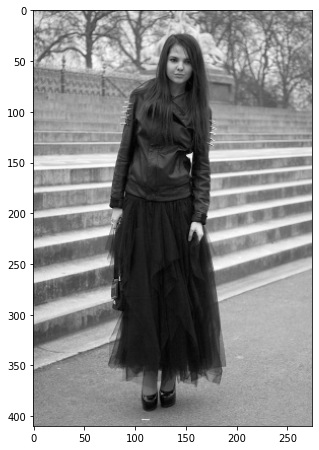

In [2]:
# The Image
image = cv2.imread(cloth_files[1], 0)
image = cv2.resize(image, (275, 410))
plt.figure(figsize=(5,8))
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.show()

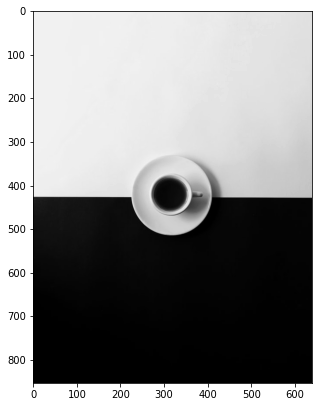

In [3]:
# The Filter
mask = cv2.imread(tea_files[8], 0)
plt.figure(figsize=(5,8))
plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
plt.show()

For the sake of simplicity, we may trim the above mask on all sides to have a smaller mask. 

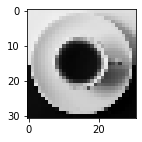

In [4]:
# trimmed mask
mask1 = mask[325:520, 220:415]
# resize to a smaller mask for better compute speed
mask1 = cv2.resize(mask1, (31,31))
plt.figure(figsize=(2,2))
plt.imshow(mask1, cmap='gray', vmin=0, vmax=255)
plt.show()

Now, what are the sizes of our image and mask?

In [5]:
print(image.shape, mask1.shape)

(410, 275) (31, 31)


100%|██████████| 379/379 [00:01<00:00, 194.01it/s]


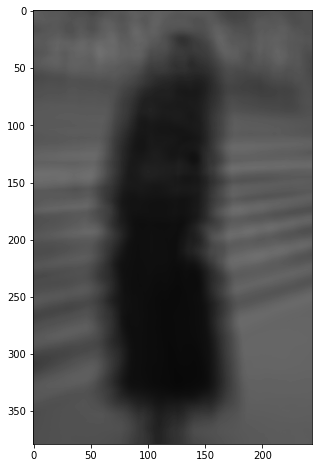

CPU times: user 2.24 s, sys: 284 ms, total: 2.53 s
Wall time: 2.18 s


In [6]:
%%time
# Perform cross-correlation by sliding the mask over the image pixel-by-pixel
# after correlation, the resulting shape will be image shape minus mask shape
result_rows = image.shape[0] - mask1.shape[0]
result_columns = image.shape[1] - mask1.shape[1]
result = np.zeros([result_rows, result_columns])

# normalize mask before processing
mask1 = mask1/255.0

# start cross-correlation
for r in tqdm(range(result_rows)):
    for c in range(result_columns):
        # now we are at result[r][c]
        val = np.multiply(image[r:r+mask1.shape[0], c:c+mask1.shape[1]], mask1)
        val = np.sum(np.ravel(val))
        # replace result value with val
        # normalize it with respect to mask size
        result[r][c] = val / np.prod(mask1.shape)

plt.figure(figsize=(5,8))
plt.imshow(result, cmap='gray', vmin=0, vmax=255)
plt.show()

## 2. Auto-Correlation

Auto-correlation is the process of correlating an image with itself. Hence the image becomes the mask!

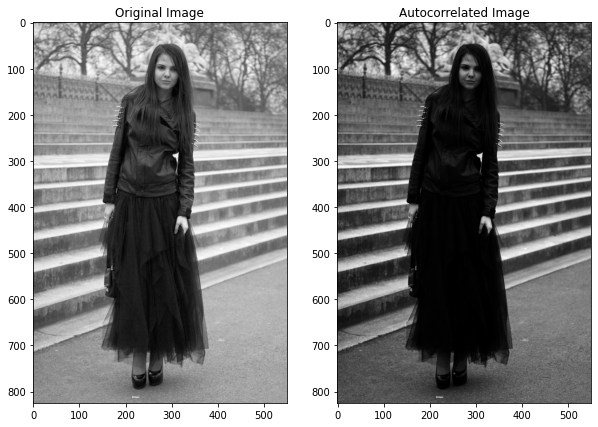

In [7]:
# read an image
image = cv2.imread(cloth_files[1], 0)

# copy image as mask
# normalize mask values
mask = image[:] / 255

# do pixel-wise multiplication
result = np.array(np.multiply(image,mask), dtype= np.uint8)

# display the result
_,(ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
ax1.imshow(image, cmap='gray', vmin=0, vmax=255)
ax2.imshow(result, cmap='gray', vmin=0, vmax=255)
ax1.set_title('Original Image')
ax2.set_title('Autocorrelated Image')
plt.show()


In [8]:
image.max(), mask.max(), result.max()

(255, 1.0, 255)

Autocorrelated image seems to have attained some enhancement by increasing contrast and darkening to some extent. Autocorrelation is widely used in signal processing, but rarely in computer vision applications.

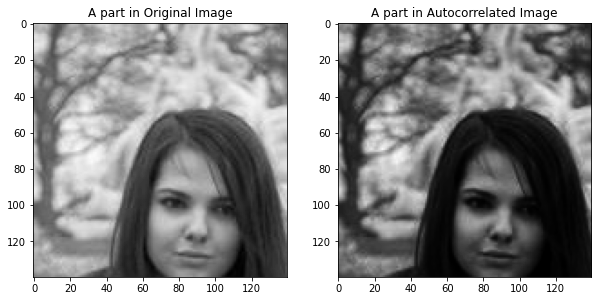

In [9]:
# Let's visualize a small portion of image to gain some idea
_,(ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
ax1.imshow(image[0:140,200:340], cmap='gray', vmin=0, vmax=255)
ax2.imshow(result[0:140,200:340], cmap='gray', vmin=0, vmax=255)
ax1.set_title('A part in Original Image')
ax2.set_title('A part in Autocorrelated Image')
plt.show()

Plot a histogram to know how far the values are stretched during autocorrelation

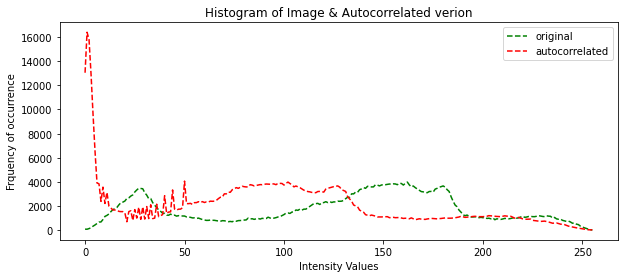

In [10]:
plt.figure(figsize=(10,4))
# histogram of original image 
intensity,count = np.unique(image, return_counts=True)
plt.plot(intensity, count, '--g', label='original')
# histogram of autocorrelated image
intensity,count = np.unique(result, return_counts=True)
plt.plot(intensity, count, '--r', label='autocorrelated')
plt.title('Histogram of Image & Autocorrelated verion')
plt.xlabel('Intensity Values')
plt.ylabel('Frquency of occurrence')
plt.legend()
plt.show()

## 3. Convolution

Convolution is a process alike cross-correlation except that the mask is double-flipped before processing. Convolution has some good mathematical properties over cross-correlation that makes it preferrable for certain image processing tasks. While convolving an image with a mask, the image may be padded with zeros or something to vary the output shape. 
There are 3 possible types of padding:
1. Valid Padding: If there is no padding, the return shape will be lesser than the original image shape. 
Return shape  = original shape  - mask shape + 1
2. Same Padding: If the image is padded such that the output shape is same as the input, it is called same padding.
Return shape = original shape
3. Full Padding: If the image is fully padded such that each element of mask is convolved with each element of the image, the output shape will be bigger than the original image.
Return shape = original shape + mask shape - 1

In [11]:
# define separate functions for both convolution and cross-correlation 
# so that they will be very handy in the future.


def cross_correlate(img, mask, padding='valid'):
    """
    The function uses padding to return the required image size.
    Mask is expected to be smaller than or equal to Image by size.
    Mask should have odd-numbered-shapes to do meaningful padding.
    Mask needs not to be square in shape
    Input image and mask should be in grayscale (for simplicity)
    """
    if mask.shape[0]>img.shape[0] or mask.shape[1]>img.shape[1]:
        raise Exception('Mask is bigger than Image!')
    if len(mask.shape)>2 or len(img.shape)>2:
        raise Exception('Please convert inputs to grayscale!')
    
    result_size = [0,0]
    
    # valid padding - returns image of smaller size than the original
    if padding=='valid':
        result_size[0] = img.shape[0] - mask.shape[0] + 1
        result_size[1] = img.shape[1] - mask.shape[1] + 1
        padded = img[:] # to have a common variable during convolution
        
    else:
        pad_size = [0,0] 
        padded_size = [0,0]
        # full padding - returns bigger image than the original
        if padding=='full':
            pad_size[0] = mask.shape[0] - 1
            pad_size[1] = mask.shape[1] - 1
            result_size[0] = img.shape[0] + mask.shape[0] - 1
            result_size[1] = img.shape[1] + mask.shape[1] - 1
        # same padding - returns image of size equal to original image
        if padding=='same':
            pad_size[0] = int((mask.shape[0] - 1)/2)
            pad_size[1] = int((mask.shape[1] - 1)/2)
            result_size[0] = img.shape[0]
            result_size[1] = img.shape[1] 
        padded_size[0] = img.shape[0] + pad_size[0]*2
        padded_size[1] = img.shape[1] + pad_size[1]*2
        # formulate a dummy padded image
        padded = np.zeros(padded_size)
        # pad the input image
        if pad_size[0] == 0:
            padded[:,pad_size[1]:-pad_size[1]] = img[:]
        elif pad_size[1] == 0:
            padded[pad_size[0]:-pad_size[0],:] = img[:]
        else:
            padded[pad_size[0]:-pad_size[0],pad_size[1]:-pad_size[1]] = img[:]
        
    
    # formulate a dummy result
    result = np.zeros(result_size)
    
    # peform cross-correlation
    for r in tqdm(range(result.shape[0])):
        for c in range(result.shape[1]):
            # we are now at result[r][c]
            val = np.multiply(padded[r:r+mask.shape[0],c:c+mask.shape[1]], mask)
            val = np.sum(np.ravel(val))
            result[r][c] = val
    
    return result
                  
def convolve(img, mask, padding='valid'):
    flipped = mask[::-1, ::-1]
    # once mask is double-flipped, convolution resembles cross-correlation
    return cross_correlate(img, flipped, padding)

Let's test the above function by passing an image and a mask

In [12]:
# create a 5 x 5 random filter
mask = np.random.random([5,5])
mask

array([[0.08379643, 0.44412287, 0.78073281, 0.01791428, 0.1707119 ],
       [0.21402534, 0.32879959, 0.36452897, 0.24976519, 0.63466977],
       [0.22561332, 0.54423095, 0.44070769, 0.75865796, 0.48943365],
       [0.00350436, 0.82570719, 0.83903261, 0.20836283, 0.48261682],
       [0.43549463, 0.97665549, 0.31276267, 0.48350184, 0.45985928]])

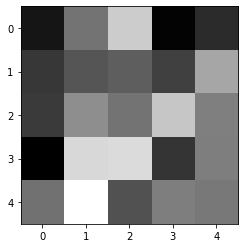

In [13]:
plt.imshow(mask, cmap='gray')
plt.show()

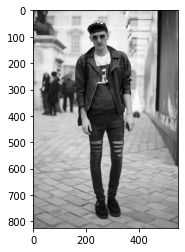

In [14]:
# an image
image = cv2.imread(cloth_files[50], 0)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.show()

100%|██████████| 821/821 [00:04<00:00, 202.95it/s]


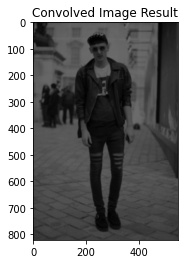

In [15]:
# perform convolution on above image and mask
res = convolve(image, mask) / np.prod(mask.shape)
plt.imshow(res, cmap='gray', vmin=0, vmax=255)
plt.title('Convolved Image Result')
plt.show()

## 4. Properties of Convolution

Convolution operation is widely used in signal processing over cross-correlation thanks to its great mathematical properties! Let's look at those properties and compare convolution and cross-correlation with respect to grayscale images.

**Commutative Property:**

a ~ b = b ~ a

where 
a - refers to image
b - refers to mask
(~) - refers to convolution operation

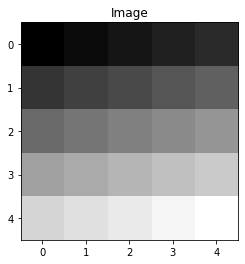

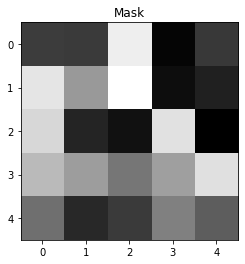

In [16]:
# formulate a simple image 
image = np.arange(25).reshape(5,-1)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

mask = np.random.random([5,5])
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()

100%|██████████| 1/1 [00:00<00:00, 3905.31it/s]


Convolution: valid padding
Is it Commutative?: True


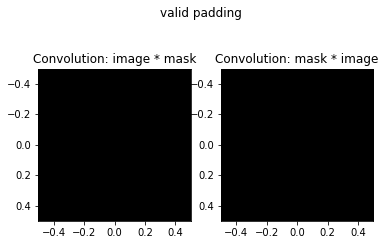

100%|██████████| 5/5 [00:00<00:00, 7866.29it/s]


Convolution: same padding
Is it Commutative?: True


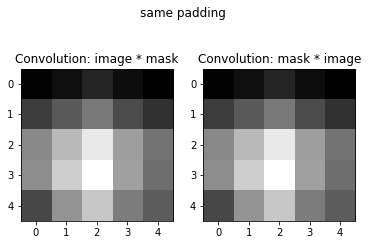

100%|██████████| 9/9 [00:00<00:00, 5801.25it/s]


Convolution: full padding
Is it Commutative?: True


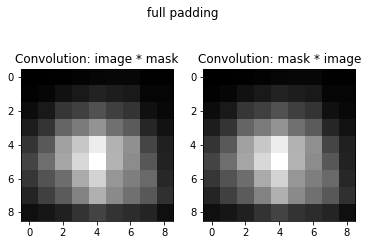

In [17]:
paddings = ['valid', 'same', 'full']
for padding in paddings:
    result1 = convolve(image, mask, padding)
    result2 = convolve(mask, image, padding)
    # are both results the same?
    print('Convolution: %s padding'%padding)
    print('Is it Commutative?: ', end='')
    print((np.float16(result1)==np.float16(result2)).all())

    # display the results
    _, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(result1, cmap='gray')
    ax1.set_title('Convolution: image * mask')

    ax2.imshow(result2, cmap='gray')
    ax2.set_title('Convolution: mask * image')
    plt.suptitle('%s padding'%padding)
    plt.show()

Yes. Both the results are same. Convolution is commutative!

*Take-away: The order of image and mask is not required. We can call an image as a mask and a mask as an image. So the two images can be interchanged.*

What about cross-correlation?

100%|██████████| 1/1 [00:00<00:00, 7489.83it/s]


Cross-correlation: valid padding
Is it Commutative?: True


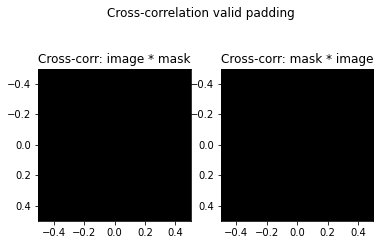

100%|██████████| 5/5 [00:00<00:00, 6905.34it/s]


Cross-correlation: same padding
Is it Commutative?: False


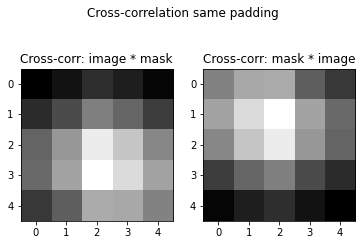

100%|██████████| 9/9 [00:00<00:00, 5960.64it/s]


Cross-correlation: full padding
Is it Commutative?: False


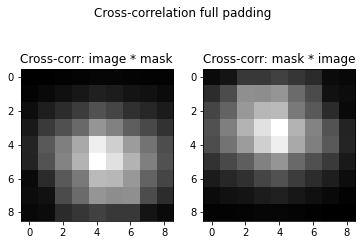

In [18]:
paddings = ['valid', 'same', 'full']
for padding in paddings:
    result1 = cross_correlate(image, mask, padding)
    result2 = cross_correlate(mask, image, padding)
    # are both results the same?
    print('Cross-correlation: %s padding'%padding)
    print('Is it Commutative?: ', end='')
    # are both results the same?
    print((np.float16(result1)==np.float16(result2)).all())

    # display the results
    _, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(result1, cmap='gray')
    ax1.set_title('Cross-corr: image * mask')

    ax2.imshow(result2, cmap='gray')
    ax2.set_title('Cross-corr: mask * image')
    plt.suptitle('Cross-correlation {:} padding'.format(padding))
    plt.show()

Cross-correlation is NOT commutative! 

**Associative Property:**

a ~ (b ~ c) = (a ~ b) ~ c

a, b, c are three images under processing

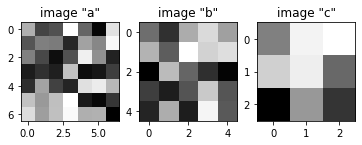

In [19]:
# define three images
a = np.random.random((7,7))
b = np.random.random((5,5))
c = np.random.random((3,3))

# display the images
_, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(a, cmap='gray')
ax1.set_title('image "a"')

ax2.imshow(b, cmap='gray')
ax2.set_title('image "b"')

ax3.imshow(c, cmap='gray')
ax3.set_title('image "c"')
plt.show()

100%|██████████| 13/13 [00:00<00:00, 5827.91it/s]


True


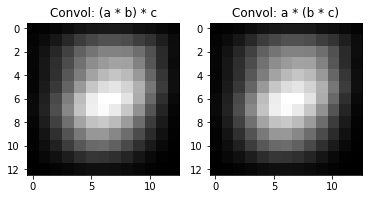

In [20]:
# perform convolution
padding='full'
result1 = convolve(convolve(a,b, padding), c, padding)
result2 = convolve(a, convolve(b,c, padding), padding)
# are both results the same?
print((np.float16(result1)==np.float16(result2)).all()) 

# display the results
_, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(result1, cmap='gray')
ax1.set_title('Convol: (a * b) * c')

ax2.imshow(result2, cmap='gray')
ax2.set_title('Convol: a * (b * c)')
plt.show()

Yes! Convolution is associative. 

*Take-away: The order of convolution operation does not matter. A series of Masks can be convolved first before making final convolution with an Image.*

What about Cross-convolution?

100%|██████████| 13/13 [00:00<00:00, 6862.06it/s]


False


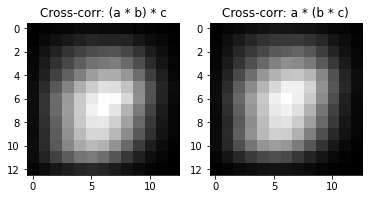

In [21]:
# perform Cross-correlation
padding='full'
result1 = cross_correlate(cross_correlate(a,b, padding), c, padding)
result2 = cross_correlate(a, cross_correlate(b,c, padding), padding)

# are both results the same?
print((np.float16(result1)==np.float16(result2)).all()) 

# display the results
_, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(result1, cmap='gray')
ax1.set_title('Cross-corr: (a * b) * c')

ax2.imshow(result2, cmap='gray')
ax2.set_title('Cross-corr: a * (b * c)')
plt.show()

Cross-correlation is not associative!

**Distributive Property**

a ~ (b + c) = (a ~ b)+ (a ~ c)

It states that two filters (of same shape) can be added together and then convolved with the image. Or, alternatively, the image can be convolved with two filters separately and then added together to achieve the same result.

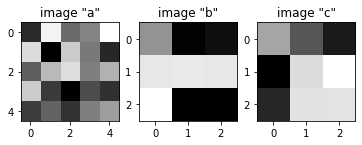

In [22]:
# define one image and two masks; 
# masks must be of same shape
a = np.random.random((5,5))
b = np.random.random((3,3))
c = np.random.random((3,3))

# display the images
_, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(a, cmap='gray')
ax1.set_title('image "a"')

ax2.imshow(b, cmap='gray')
ax2.set_title('image "b"')

ax3.imshow(c, cmap='gray')
ax3.set_title('image "c"')
plt.show()

100%|██████████| 3/3 [00:00<00:00, 8924.05it/s]


Convolution: valid padding
Is it Distributive?: True


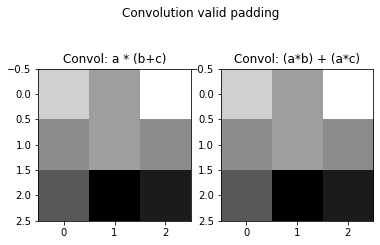

100%|██████████| 5/5 [00:00<00:00, 14583.81it/s]


Convolution: same padding
Is it Distributive?: True


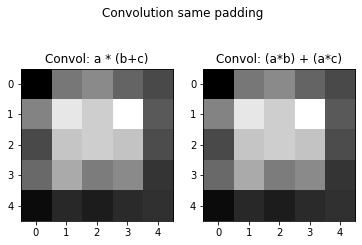

100%|██████████| 7/7 [00:00<00:00, 6929.46it/s]


Convolution: full padding
Is it Distributive?: True


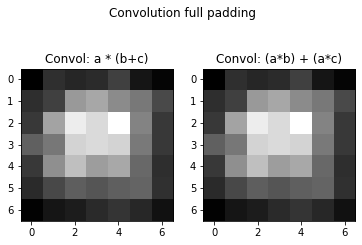

In [23]:
# perform convolution
paddings= ['valid', 'same', 'full']
for padding in paddings:
    result1 = convolve(a, (b+c), padding)
    result2 = convolve(a,b,padding) + convolve(a,c,padding)
    # are both results the same?
    print('Convolution: %s padding'%padding)
    print('Is it Distributive?: ', end='')
    print((np.float16(result1)==np.float16(result2)).all()) 

    # display the results
    _, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(result1, cmap='gray')
    ax1.set_title('Convol: a * (b+c)')

    ax2.imshow(result2, cmap='gray')
    ax2.set_title('Convol: (a*b) + (a*c)')
    plt.suptitle('Convolution {} padding'.format(padding))
    plt.show()

Evidently, convolution is distributive! 

*Takeaway: We can split operations or merge operations whenever possible.*

What about cross-correlation?

100%|██████████| 3/3 [00:00<00:00, 9931.26it/s]


Cross-correlation: valid padding
Is it Distributive?: False


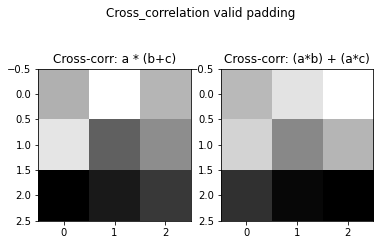

100%|██████████| 5/5 [00:00<00:00, 6919.01it/s]


Cross-correlation: same padding
Is it Distributive?: False


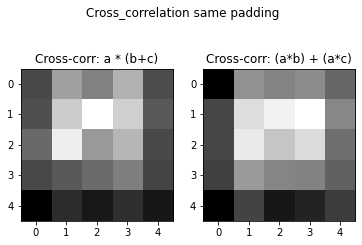

100%|██████████| 7/7 [00:00<00:00, 8155.59it/s]


Cross-correlation: full padding
Is it Distributive?: False


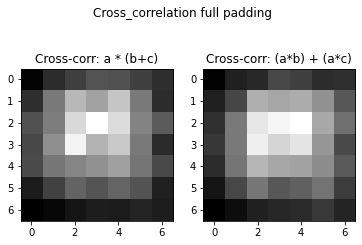

In [24]:
# perform Cross-correlation
paddings= ['valid', 'same', 'full']
for padding in paddings:
    result1 = cross_correlate(a, (b+c), padding)
    result2 = cross_correlate(a,b,padding) + convolve(a,c,padding)
    # are both results the same?
    print('Cross-correlation: %s padding'%padding)
    print('Is it Distributive?: ', end='')
    print((np.float16(result1)==np.float16(result2)).all()) 

    # display the results
    _, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(result1, cmap='gray')
    ax1.set_title('Cross-corr: a * (b+c)')

    ax2.imshow(result2, cmap='gray')
    ax2.set_title('Cross-corr: (a*b) + (a*c)')
    plt.suptitle('Cross_correlation {} padding'.format(padding))
    plt.show()

Cross-correlation is NOT distributive. We have to perform the operations as intended.

**Scalar Property:**

ka ~ b = a ~ kb = k (a ~ b)

If there is a scalar, it can be multiplied either with image or with mask before doing convolution, or, alternatively, it can be multiplied with the result after doing convolution.

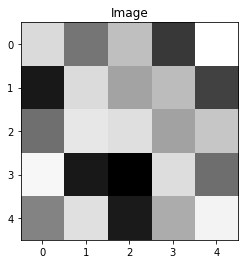

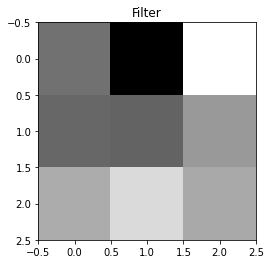

In [25]:
# have an image and a mask
a = np.random.random((5,5))
b = np.random.random((3,3))

plt.imshow(a, cmap='gray')
plt.title('Image')
plt.show()

plt.imshow(b, cmap='gray')
plt.title('Filter')
plt.show()

100%|██████████| 3/3 [00:00<00:00, 7602.97it/s]


Convolution: valid padding
Convolution has Scalar property:  True True


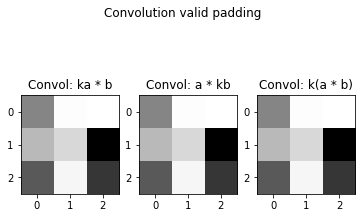

100%|██████████| 5/5 [00:00<00:00, 8591.36it/s]


Convolution: same padding
Convolution has Scalar property:  True True


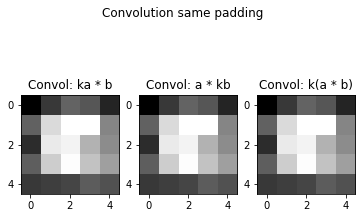

100%|██████████| 7/7 [00:00<00:00, 7478.38it/s]


Convolution: full padding
Convolution has Scalar property:  True True


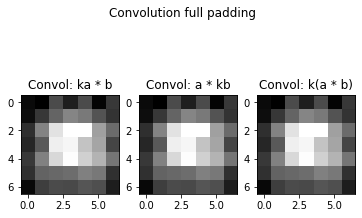

In [26]:
# declare a scalar
k = 5
# perform convolution
paddings= ['valid', 'same', 'full']
for padding in paddings:
    result1 = convolve(k*a, b, padding)
    result2 = convolve(a, k*b, padding)
    result3 = k*convolve(a, b, padding)
    # are both results the same?
    print('Convolution: %s padding'%padding)
    print('Convolution has Scalar property: ', end=' ')
    print((np.float16(result1)==np.float16(result2)).all(), end=' ') 
    print((np.float16(result1)==np.float16(result3)).all()) 

    # display the results
    _, (ax1, ax2, ax3) = plt.subplots(1,3)
    ax1.imshow(result1, cmap='gray')
    ax1.set_title('Convol: ka * b')

    ax2.imshow(result2, cmap='gray')
    ax2.set_title('Convol: a * kb')
    
    ax3.imshow(result3, cmap='gray')
    ax3.set_title('Convol: k(a * b)')
    plt.suptitle('Convolution {} padding'.format(padding))
    plt.show()

Great! Scalar multiplications do impose no effect on convolution process.

What about cross-correlation?

100%|██████████| 3/3 [00:00<00:00, 10131.17it/s]


Cross_correlation: valid padding
Cross_correlation has Scalar property:  True True


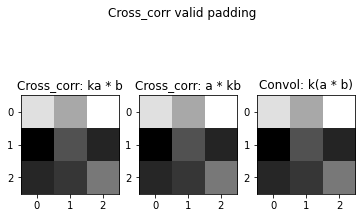

100%|██████████| 5/5 [00:00<00:00, 12748.64it/s]


Cross_correlation: same padding
Cross_correlation has Scalar property:  True True


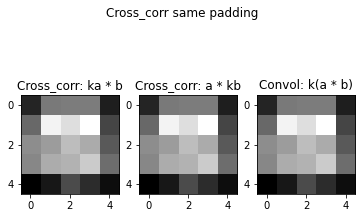

100%|██████████| 7/7 [00:00<00:00, 11464.32it/s]


Cross_correlation: full padding
Cross_correlation has Scalar property:  True True


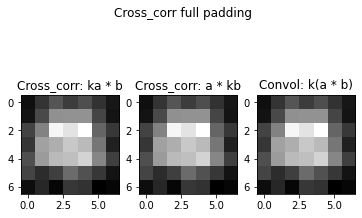

In [27]:
# declare a scalar
k = 5
# perform cross-correlation
paddings= ['valid', 'same', 'full']
for padding in paddings:
    result1 = cross_correlate(k*a, b, padding)
    result2 = cross_correlate(a, k*b, padding)
    result3 = k*cross_correlate(a, b, padding)
    # are both results the same?
    print('Cross_correlation: %s padding'%padding)
    print('Cross_correlation has Scalar property: ', end=' ')
    print((np.float16(result1)==np.float16(result2)).all(), end=' ') 
    print((np.float16(result1)==np.float16(result3)).all()) 

    # display the results
    _, (ax1, ax2, ax3) = plt.subplots(1,3)
    ax1.imshow(result1, cmap='gray')
    ax1.set_title('Cross_corr: ka * b')

    ax2.imshow(result2, cmap='gray')
    ax2.set_title('Cross_corr: a * kb')
    
    ax3.imshow(result3, cmap='gray')
    ax3.set_title('Convol: k(a * b)')
    plt.suptitle('Cross_corr {} padding'.format(padding))
    plt.show()

That's remarkable! Cross-correlation fulfills scalar property.

**Impulse Property**

e ~ a = a

where a refers to an image and e refers to an impulse function (can be 1D, 2D, or 3D)

100%|██████████| 5/5 [00:00<00:00, 10866.07it/s]


Convolution has Impulse property:  True


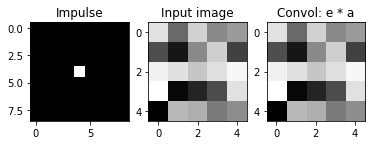

In [28]:
# create an impulse function with central pixel possessing the max value
# and remaining pixels the min value
e = np.zeros((9,9))
e[e.shape[0]//2, e.shape[1]//2] = 1

# create an image
a = np.random.random((5,5))

result = convolve(e, a, padding='valid')
# is the result same as input image?
print('Convolution has Impulse property: ', end=' ')
print((np.float16(result)==np.float16(a)).all()) 

# display the results
_, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(e, cmap='gray')
ax1.set_title('Impulse')

ax2.imshow(a, cmap='gray')
ax2.set_title('Input image')
    
ax3.imshow(result, cmap='gray')
ax3.set_title('Convol: e * a')
plt.show()

Yes. Convolution satisfies Impulse property. Input image resembles the output image.

Does Cross-Correlation satisfy this property?

100%|██████████| 5/5 [00:00<00:00, 12725.44it/s]


Cross-correlation has Impulse property:  False


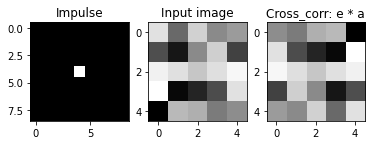

In [29]:
result = cross_correlate(e, a, padding='valid')
# is the result same as input image?
print('Cross-correlation has Impulse property: ', end=' ')
print((np.float16(result)==np.float16(a)).all()) 

# display the results
_, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(e, cmap='gray')
ax1.set_title('Impulse')

ax2.imshow(a, cmap='gray')
ax2.set_title('Input image')
    
ax3.imshow(result, cmap='gray')
ax3.set_title('Cross_corr: e * a')
plt.show()

Cross-correlation double flips the input image when processed with an impulse function. Let's have a real-life image to have better visualization!

100%|██████████| 155/155 [00:00<00:00, 195.12it/s]


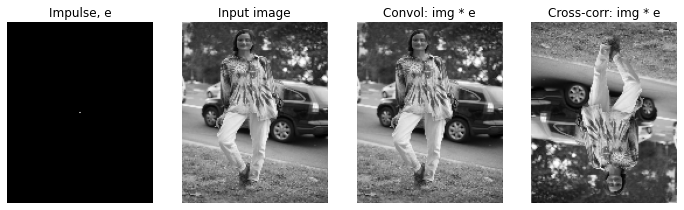

In [30]:
# create an impulse function with central pixel possessing the max value
# and remaining pixels the min value
e = np.zeros((155,125))
e[e.shape[0]//2, e.shape[1]//2] = 1

# read an image from input files
img = cv2.imread(cloth_files[80],0)
img = cv2.resize(img,(125,155))
conv_result = convolve(e, img, padding='same')
cc_result = cross_correlate(e, img, padding='same')

# display the results
_, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12,4))
ax1.imshow(e, cmap='gray')
ax1.set_title('Impulse, e')
ax1.axis('off')

ax2.imshow(img, cmap='gray')
ax2.set_title('Input image')
ax2.axis('off')
    
ax3.imshow(conv_result, cmap='gray')
ax3.set_title('Convol: img * e')
ax3.axis('off')

ax4.imshow(cc_result, cmap='gray')
ax4.set_title('Cross-corr: img * e')
ax4.axis('off')
plt.show()

## 5. Moving Average Filter

Moving average filter is also known as Box filter or Blurring filter or Smoothing filter. It is a square filter of size usually 3, 5, or 7. The pixel values of the filter are equal by value. This filter smoothens the input image and removes high-frequency edges from the image. Hence this filter comes under the category of low-pass filters. 

A low-pass filter allows low-frequency elements while filtering out high-frequency elements. A high-pass filter does a job quite opposite to that of a low-pass filter.

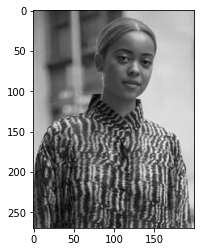

In [31]:
img = cv2.imread(cloth_files[90],0)
img = img[30:300,150:350]
plt.imshow(img, cmap='gray')
plt.show()

This is a 3x3 moving average filter
[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


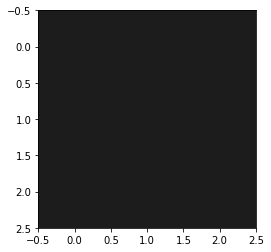

100%|██████████| 270/270 [00:00<00:00, 536.98it/s]


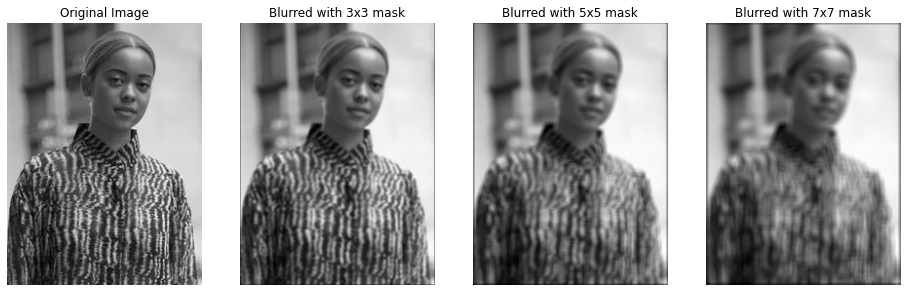

In [32]:
# a function for moving average filter
def moving_avg(size=3):
    mask = np.ones((size,size))
    # normalize the filter
    return mask / np.sum(mask)
    
# read an image from input files
img = cv2.imread(cloth_files[90],0)
img = img[30:300,150:350]
# create three different sized filters
mask3 = moving_avg(3)
mask5 = moving_avg(5)
mask7 = moving_avg(7) 

# print a mask for better understanding
print('This is a 3x3 moving average filter')
print(mask3)
plt.imshow(mask3, cmap='gray', vmin=0, vmax=1)
plt.show()

# display the images
_, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,5))
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(convolve(img,mask3,padding='same'), cmap='gray')
ax2.set_title('Blurred with 3x3 mask')
ax2.axis('off')
    
ax3.imshow(convolve(img,mask5,padding='same'), cmap='gray')
ax3.set_title('Blurred with 5x5 mask')
ax3.axis('off')

ax4.imshow(convolve(img,mask7,padding='same'), cmap='gray')
ax4.set_title('Blurred with 7x7 mask')
ax4.axis('off')
plt.show()

## 6. Gaussian Filter

Gaussian filter is also a low-pass smoothing filter, but it could retain some minor details unlike a moving-average filter. It gives more weightage to central pixel and as the distance goes on, weightage is NORMALLY fallen down. Gaussian filter is widely used in digital camera / image processing industry to remove certain noises, to do downsampling and upsampling, and to do anti-alaising. 

In [33]:
# A simple N-sized gaussian kernel with standard deviation STD
def gaussian(size=3,std=1.0):
    k = signal.gaussian(size,std=std)
    # obtain 2D kernel from 1D kernel
    kernel = np.outer(k,k)
    # normalize the values
    return kernel / np.sum(kernel)

This is a 3x3 Gaussian filter
[[0.06047636 0.1249667  0.06047636]
 [0.1249667  0.25822777 0.1249667 ]
 [0.06047636 0.1249667  0.06047636]]


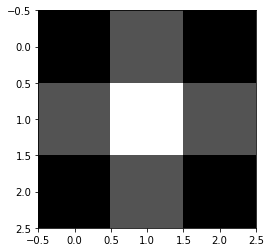

This is a 5x5 Gaussian filter
[[0.00353824 0.01454903 0.02330859 0.01454903 0.00353824]
 [0.01454903 0.05982466 0.09584343 0.05982466 0.01454903]
 [0.02330859 0.09584343 0.1535481  0.09584343 0.02330859]
 [0.01454903 0.05982466 0.09584343 0.05982466 0.01454903]
 [0.00353824 0.01454903 0.02330859 0.01454903 0.00353824]]


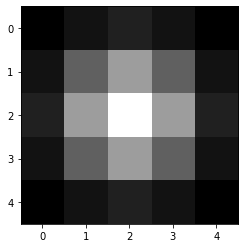

This is a 7x7 Gaussian filter
[[0.00084073 0.00301024 0.00647097 0.00835139 0.00647097 0.00301024
  0.00084073]
 [0.00301024 0.01077825 0.02316949 0.02990239 0.02316949 0.01077825
  0.00301024]
 [0.00647097 0.02316949 0.04980635 0.06427974 0.04980635 0.02316949
  0.00647097]
 [0.00835139 0.02990239 0.06427974 0.082959   0.06427974 0.02990239
  0.00835139]
 [0.00647097 0.02316949 0.04980635 0.06427974 0.04980635 0.02316949
  0.00647097]
 [0.00301024 0.01077825 0.02316949 0.02990239 0.02316949 0.01077825
  0.00301024]
 [0.00084073 0.00301024 0.00647097 0.00835139 0.00647097 0.00301024
  0.00084073]]


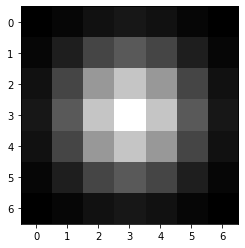

100%|██████████| 270/270 [00:00<00:00, 558.50it/s]


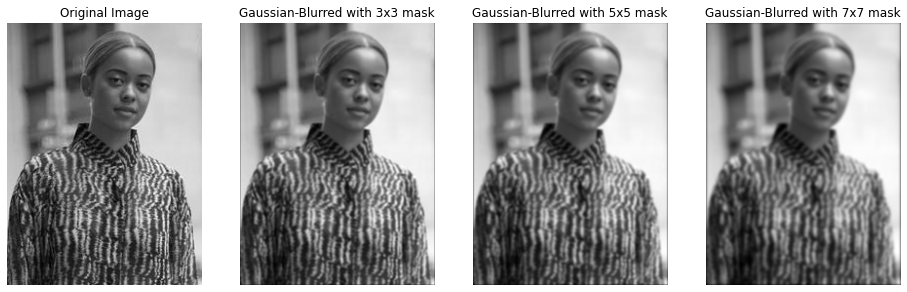

In [34]:
# read an image from input files
img = cv2.imread(cloth_files[90],0)
img = img[30:300,150:350]
# create three different sized filters with some common std 
# the mask values can be varied with std
mask3 = gaussian(size=3, std=0.83)
mask5 = gaussian(size=5, std=1.03)
mask7 = gaussian(size=7, std=1.40)

i=1
for mask in [mask3,mask5,mask7]:    # print a mask for better understanding
    i += 2
    print('This is a {}x{} Gaussian filter'.format(i,i))
    print(mask)
    plt.imshow(mask, cmap='gray')
    plt.show()

# display the images
_, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,5))
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(convolve(img,mask3,padding='same'), cmap='gray')
ax2.set_title('Gaussian-Blurred with 3x3 mask')
ax2.axis('off')
    
ax3.imshow(convolve(img,mask5,padding='same'), cmap='gray')
ax3.set_title('Gaussian-Blurred with 5x5 mask')
ax3.axis('off')

ax4.imshow(convolve(img,mask7,padding='same'), cmap='gray')
ax4.set_title('Gaussian-Blurred with 7x7 mask')
ax4.axis('off')
plt.show()

It can be observed that Gaussian filter smoothens the image while retaining most finer details compared to moving average filter.

## 7. Edge Filter

Edge filters are yet another popular filters category. They find either horizontal edges or vertical edges, or both the horizontal and vertical edges. These filters are high-pass filters since they pass the high-frequency components (edges) and block low-frequency components (other than edges). In the resulting image, edges retain high intensity values (close to MAX) while the remaining portions possess negligible intensity values (close to MIN).

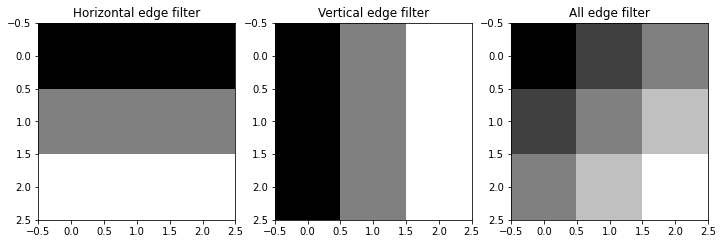

100%|██████████| 427/427 [00:02<00:00, 168.58it/s]


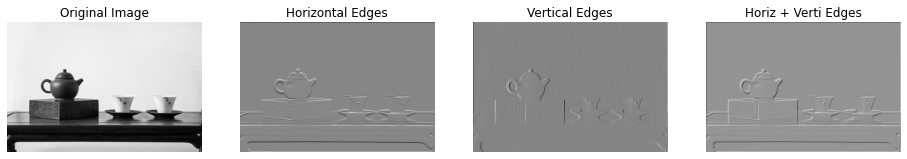

In [35]:
horiz_edge = np.array([[-1,-1,-1],
                        [0,0,0],
                        [1,1,1]])
verti_edge = horiz_edge.T
both_edge = horiz_edge + verti_edge

# display the filters
# display the images
_, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
ax1.imshow(horiz_edge, cmap='gray')
ax1.set_title('Horizontal edge filter')

ax2.imshow(verti_edge, cmap='gray')
ax2.set_title('Vertical edge filter')
    
ax3.imshow(both_edge, cmap='gray')
ax3.set_title('All edge filter')
plt.show()

# read an image from input files
img = cv2.imread(tea_files[120],0)
#img = img[30:300,150:350]

# display the images
_, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,6))
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(convolve(img,horiz_edge,padding='same'), cmap='gray')
ax2.set_title('Horizontal Edges')
ax2.axis('off')
    
ax3.imshow(convolve(img,verti_edge,padding='same'), cmap='gray')
ax3.set_title('Vertical Edges')
ax3.axis('off')

ax4.imshow(convolve(img,both_edge,padding='same'), cmap='gray')
ax4.set_title('Horiz + Verti Edges')
ax4.axis('off')
plt.show()

## 8. Separable Filters

Computer Vision has found a drastic growth in recent times thanks to great compute capacities nowadays. However, the computation complexity should be kept as minimal as possible to handle resources efficiently. In this context, filters that are 'separable' must be broken down into smaller-dimensional vectors, convolved separately, and merged finally. 

For instance, the moving average filter, Gaussian filter, edge filter that we have discussed above are all separable filters. These 2D filters can be broken down into two 1D filters such that the outer product of the 1D filter may result in the 2D filters.

Time complexity in 2D filter convolution 
= O(image_width * image_height * filter_width * filter_height)

Time complexity in 1D filter convolution 
= O(image_width * image_height * filter_width)

Let's analyze time taken for convolution with 2D and 1D filters to attain same results.

**Moving Average filter**

100%|██████████| 825/825 [00:04<00:00, 199.71it/s]


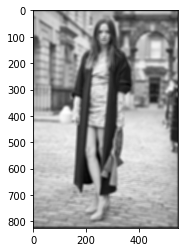

CPU times: user 4.61 s, sys: 172 ms, total: 4.78 s
Wall time: 4.53 s


In [36]:
%%time
# a 2D filter of size 11*11
mask = np.ones((11,11))
mask = mask / np.sum(mask)
image = cv2.imread(cloth_files[40],0)
result_2D = convolve(image,mask,padding='same')
# display the result
plt.imshow(result_2D, cmap='gray')
plt.show()

100%|██████████| 825/825 [00:03<00:00, 206.98it/s]


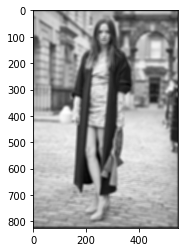

CPU times: user 8.24 s, sys: 206 ms, total: 8.45 s
Wall time: 8.16 s


In [37]:
%%time
# a 1D filter of size 11*1
mask = np.ones((11,1)) 
mask = mask / np.sum(mask)
image = cv2.imread(cloth_files[40],0)
# do TWO convolutions one with column vector and another with a row vector
result_1D = convolve(convolve(image,mask,padding='same'), mask.T,padding='same')
# display the result
plt.imshow(result_1D, cmap='gray')
plt.show()

Here, unfortunately, NumPy beats us on Matrix multiplication. 2D convolution is a single-pass code, but tedious. 1D convolution is a two-pass code but mathematically simple. In the above processes, NumPy uses a highly-optimized method to do high-dimensional matrix multiplication efficiently. Hence, more time is spent with separable filters but not with 2D filter. Our complexity claim can be proved if use a naive-for-loop to iterate over rows and columns to do matrix multiplication.

Python libraries and frameworks such as NumPy, TensorFlow, PyTorch and SciPy are using their best optimization algorithms such as Fast Fourier Transforms, BLAS wherever possible to do efficient processing.

Okay. Let's return back to our separable filters. Are both the results same?

In [38]:
(np.float16(result_1D) == np.float16(result_2D)).all()

True

In Gaussian Filter, we could recall that we have formulated a 2D filter by performing an outer product with two instances of an identical 1D filter. 

Moreover, the above edge filters can also be separated into 1D filters that are not identical. As an optimization and simplication step, a filter, if possible, must be broken down into smaller-dimensional filters.

#### Thank you for your time!